In [1]:
import kagglehub
sani84_glasmiccai2015_gland_segmentation_path = kagglehub.dataset_download('sani84/glasmiccai2015-gland-segmentation')

print(f'Data source import complete at {sani84_glasmiccai2015_gland_segmentation_path}')

Data source import complete at /kaggle/input/glasmiccai2015-gland-segmentation


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image
import os
import shutil
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.models.segmentation import deeplabv3_resnet50
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
import cv2
from torchmetrics.classification import BinaryF1Score
import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Initialize lists
train_image_files, train_mask_files = [], []
test_image_files, test_mask_files = [], []

DATA_DIR = '/kaggle/input/glasmiccai2015-gland-segmentation'

# Walk through the dataset directory
for dirpath, _, filenames in os.walk(DATA_DIR):
    bmp_files = [f for f in filenames if f.endswith('.bmp')]
    print(f"Scanning: {dirpath} — found {len(bmp_files)} .bmp files")

    for filename in bmp_files:
        # ---- TRAIN FILES ----
        if filename.startswith('train') and filename.endswith('_anno.bmp'):
            file_prefix = filename.replace('_anno.bmp', '')
            mask_path = os.path.join(dirpath, filename)
            image_path = os.path.join(dirpath, f"{file_prefix}.bmp")

            if os.path.exists(image_path):
                train_mask_files.append(mask_path)
                train_image_files.append(image_path)

        # ---- TEST FILES ----
        elif filename.startswith('test') and filename.endswith('_anno.bmp'):
            file_prefix = filename.replace('_anno.bmp', '')
            mask_path = os.path.join(dirpath, filename)
            image_path = os.path.join(dirpath, f"{file_prefix}.bmp")

            if os.path.exists(image_path):
                test_mask_files.append(mask_path)
                test_image_files.append(image_path)

# ---- Summary ----
print(f"\n Found {len(train_image_files)} training images and {len(train_mask_files)} masks.")
print(f" Found {len(test_image_files)} testing images and {len(test_mask_files)} masks.")


Scanning: /kaggle/input/glasmiccai2015-gland-segmentation — found 0 .bmp files
Scanning: /kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset — found 330 .bmp files

 Found 85 training images and 85 masks.
 Found 80 testing images and 80 masks.


 Training set preview:
Displaying 5 random image–mask pairs...

Mask value stats → unique values: [0 1 2], count: 3
Mask mode: L


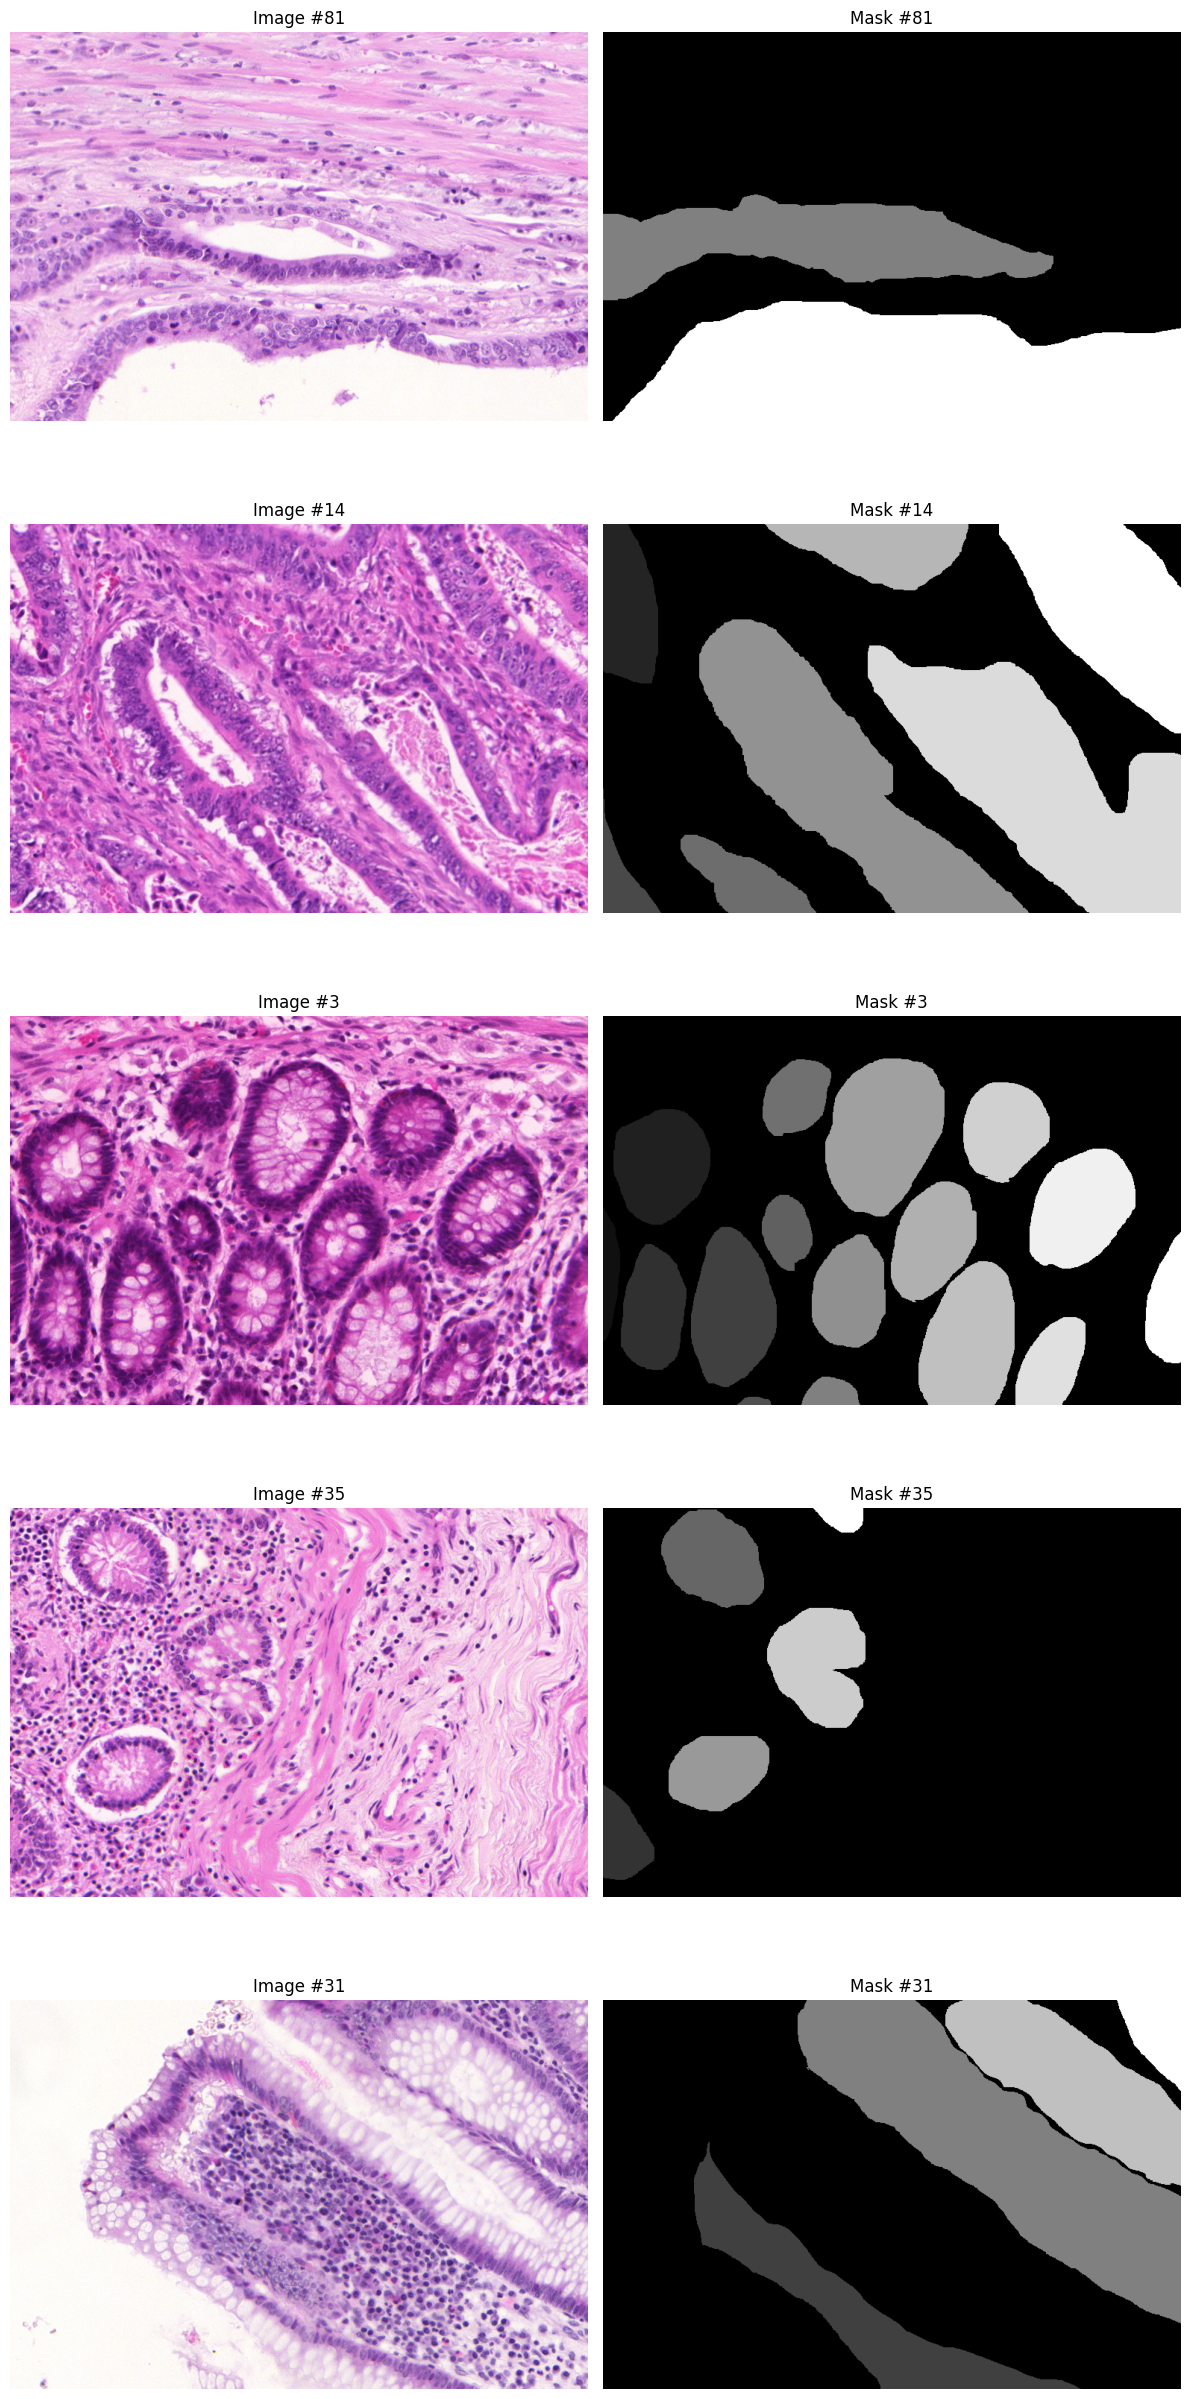

Test set preview:
Displaying 5 random image–mask pairs...

Mask value stats → unique values: [0 1 2], count: 3
Mask mode: L


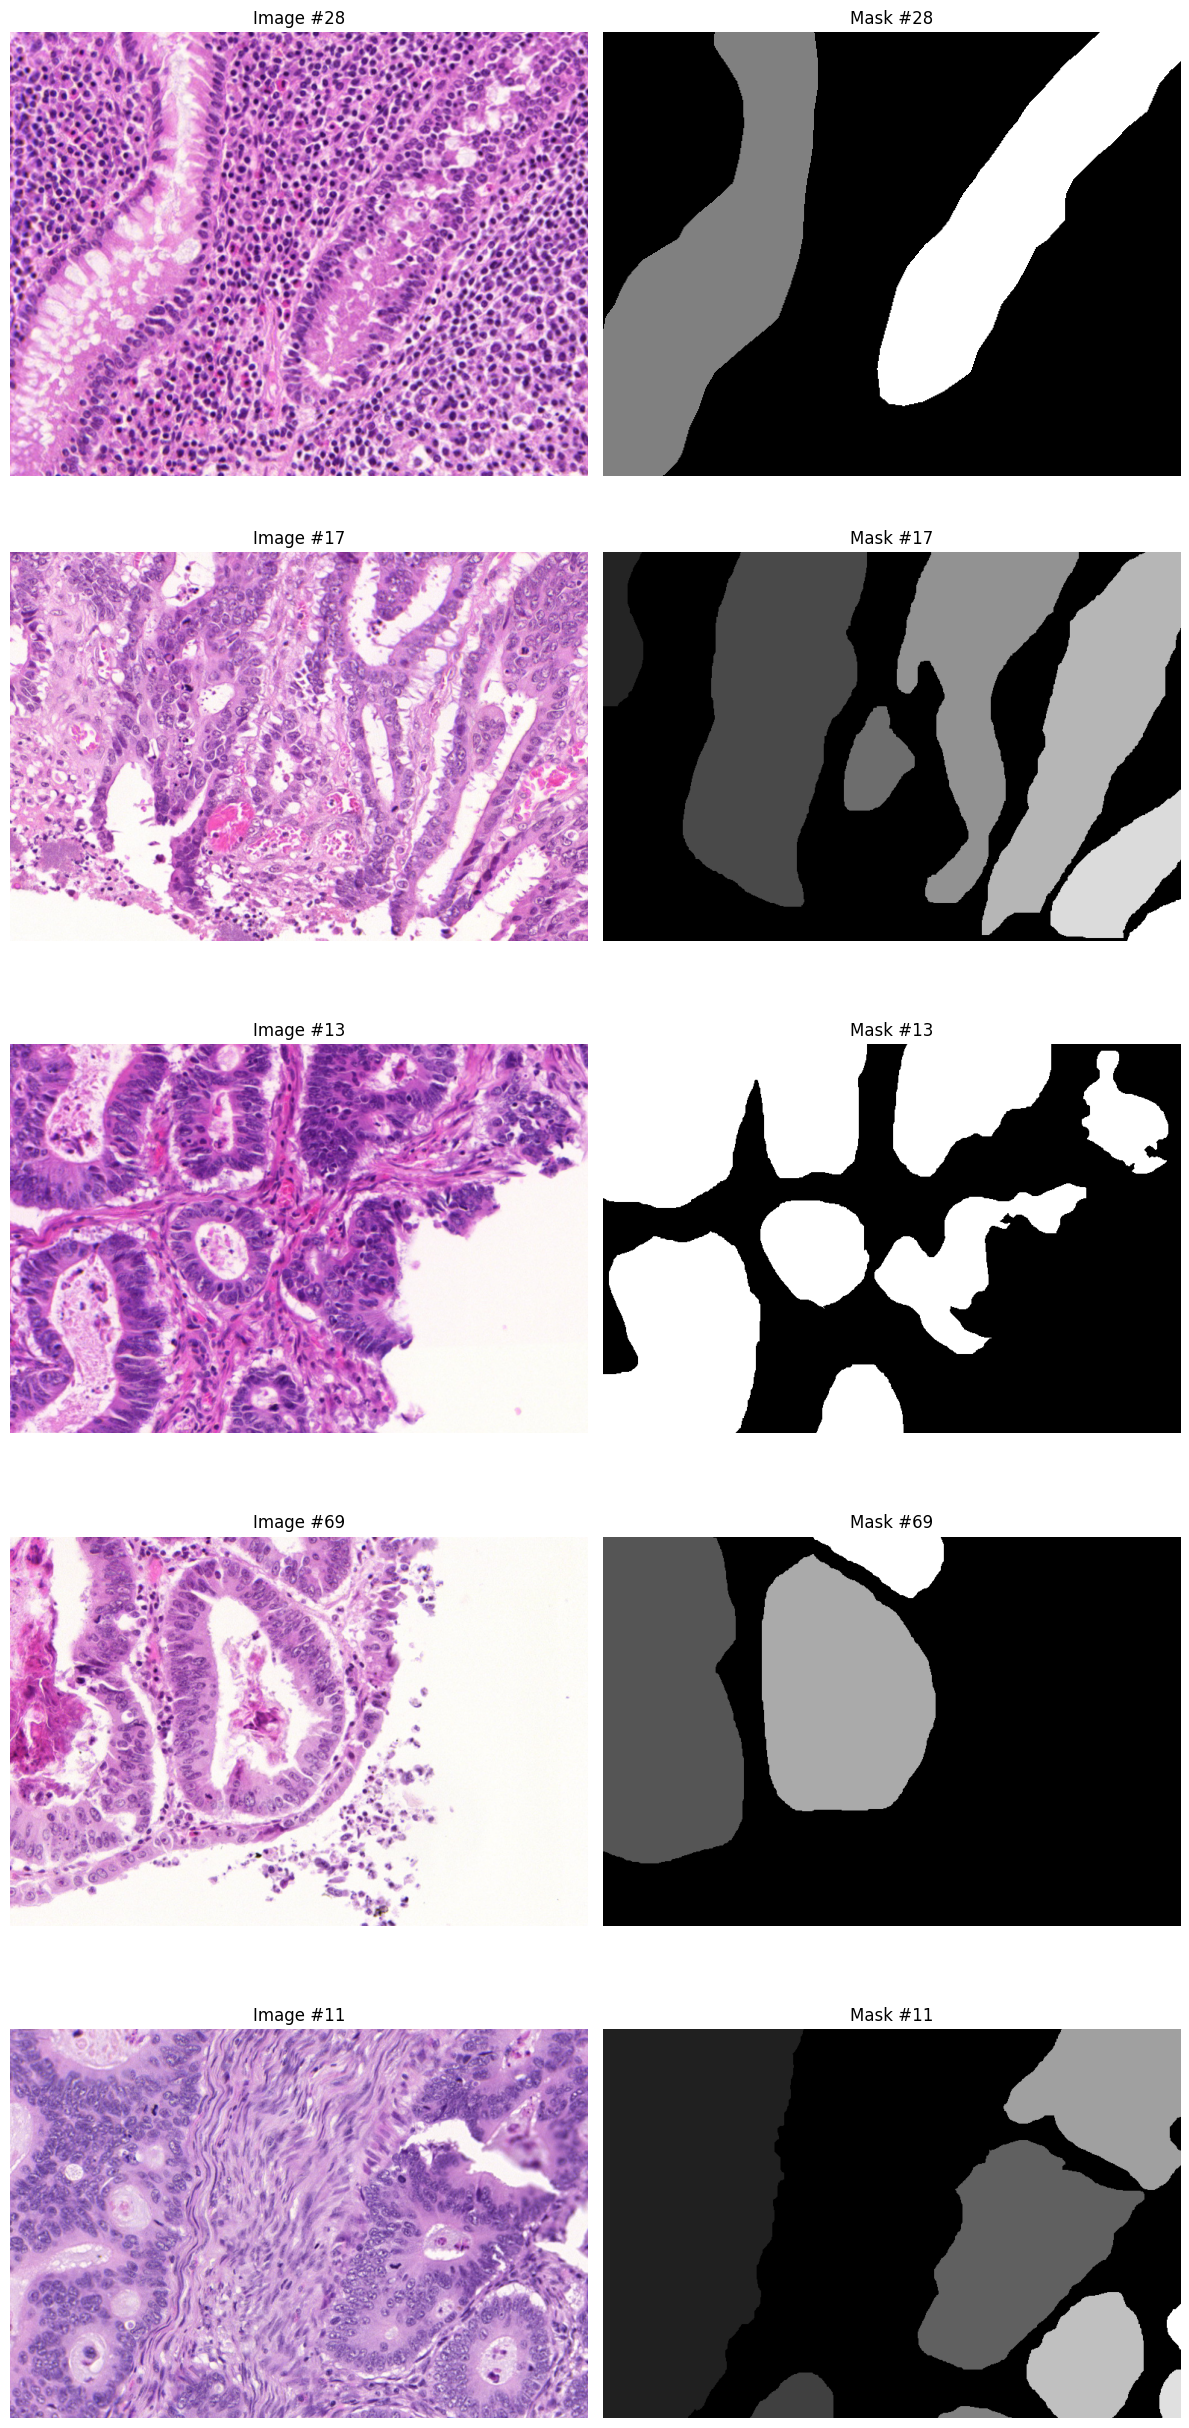

In [7]:
def display_random_images_and_masks(image_files, mask_files, num_samples=5):
    """
    Display random image–mask pairs side by side for quick visual verification.

    Args:
        image_files (list): List of file paths to input images.
        mask_files (list): List of file paths to corresponding masks.
        num_samples (int): Number of random samples to display.
    """
    # --- Basic checks ---
    if len(image_files) == 0 or len(mask_files) == 0:
        print("No image or mask files found. Please check dataset paths.")
        return
    if len(image_files) != len(mask_files):
        print(f"Mismatch: {len(image_files)} images vs {len(mask_files)} masks.")
        return

    # --- Random sampling ---
    indices = random.sample(range(len(image_files)), min(num_samples, len(image_files)))

    # --- Plot setup ---
    fig, axes = plt.subplots(len(indices), 2, figsize=(12, len(indices) * 5))
    if len(indices) == 1:
        axes = np.expand_dims(axes, 0)  # ensure 2D array of axes

    print(f"Displaying {len(indices)} random image–mask pairs...\n")

    for i, idx in enumerate(indices):
        img_path = image_files[idx]
        mask_path = mask_files[idx]

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Detect mask characteristics only for the first sample
        if i == 0:
            mask_cv = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            if mask_cv is not None:
                if mask_cv.ndim == 3:
                    mask_cv = mask_cv[..., 0]  # take one channel if RGB repeated
                unique_vals = np.unique(mask_cv)
                print(f"Mask value stats → unique values: {unique_vals}, count: {len(unique_vals)}")
                print(f"Mask mode: {mask.mode}")

        # Plot image
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Image #{idx}")
        axes[i, 0].axis("off")

        # Plot mask
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title(f"Mask #{idx}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

print(" Training set preview:")
display_random_images_and_masks(train_image_files, train_mask_files, num_samples=5)

print("Test set preview:")
display_random_images_and_masks(test_image_files, test_mask_files, num_samples=5)


In [5]:
from tqdm import tqdm

def compute_image_stats(image_paths, mask_paths=None):
    """
    Compute the per-channel mean and standard deviation of a dataset of RGB images.
    Optionally also checks mask statistics if mask_paths are provided.

    Args:
        image_paths (list): List of image file paths.
        mask_paths (list, optional): List of mask file paths (for info only).

    Returns:
        tuple: (mean, std) — torch tensors with 3 elements each.
    """
    if not image_paths:
        raise ValueError("No image paths provided. Please check your dataset list.")

    # Initialize accumulators for mean and variance
    n_images = len(image_paths)
    sum_rgb = torch.zeros(3)
    sum_sq_rgb = torch.zeros(3)

    print(f"Computing dataset statistics for {n_images} images...")

    # Loop through all images
    for img_path in tqdm(image_paths, desc="Processing images"):
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img, dtype=np.float32) / 255.0  # scale to [0, 1]
        img_t = torch.from_numpy(img_np).permute(2, 0, 1)  # shape [C, H, W]

        # Compute per-channel mean and squared mean
        mean = img_t.mean(dim=(1, 2))
        sq_mean = (img_t ** 2).mean(dim=(1, 2))

        sum_rgb += mean
        sum_sq_rgb += sq_mean

    # Dataset mean and std
    mean = sum_rgb / n_images
    std = torch.sqrt(sum_sq_rgb / n_images - mean ** 2)

    print(f"\n Dataset statistics:")
    print(f"  • Mean per channel: {mean.tolist()}")
    print(f"  • Std per channel : {std.tolist()}")

    

    return mean, std

# Example usage
image_paths = sorted(train_image_files)
mean, std = compute_image_stats(image_paths, mask_paths=train_mask_files)


Computing dataset statistics for 85 images...


Processing images: 100%|██████████| 85/85 [00:02<00:00, 34.86it/s]


 Dataset statistics:
  • Mean per channel: [0.7874336838722229, 0.5111792087554932, 0.7851389050483704]
  • Std per channel : [0.167929008603096, 0.24850618839263916, 0.13226564228534698]


In [6]:
# ============================================================
#  Reproducibility and Device Setup
# ============================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================================================
#  Hyperparameters
# ============================================================
NUM_CLASSES   = 2
BATCH_SIZE    = 6
IMG_RESIZE    = 512
LR            = 1e-4
WEIGHT_DECAY  = 1e-4
NUM_EPOCHS    = 80
PATIENCE      = 15       # early stopping patience
CROP_SIZE     = 512
NUM_WORKERS   = 2
PRINT_FREQ    = 20
CHECKPOINT_DIR = "/kaggle/working/content/checkpoints"

# ============================================================
#  Normalization for ResNet50 Backbone
# ============================================================
# Common ImageNet normalization (default for pretrained ResNet)
# histimg_mean = (0.485, 0.456, 0.406)
# histimg_std  = (0.229, 0.224, 0.225)

# If you computed dataset-specific values via compute_image_stats:
histimg_mean = ()   # <-- fill with your dataset mean (R,G,B)
histimg_std  = ()   # <-- fill with your dataset std  (R,G,B)

# ============================================================
#  Mask color mapping (for RGB mask encoding)
# ============================================================
# Example: background black (0,0,0), gland red (255,0,0)
color2id = {(0, 0, 0): 0, (255, 0, 0): 1}
COLORMAP = np.array([(0, 0, 0), (255, 0, 0)], dtype=np.uint8)

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ============================================================
#  Utility: RGB mask → Class ID mask
# ============================================================
def rgb_to_mask_array(rgb_mask, color2id):
    """
    Converts an RGB-encoded mask image to a single-channel class ID mask.
    Unknown colors are assigned the value 255 (ignored during training).
    """
    h, w, _ = rgb_mask.shape
    mask = np.ones((h, w), dtype=np.uint8) * 255
    flat_rgb = rgb_mask.reshape(-1, 3)
    mask_flat = mask.reshape(-1)

    for (r, g, b), class_id in color2id.items():
        matches = np.all(flat_rgb == np.array([r, g, b], dtype=np.uint8), axis=1)
        mask_flat[matches] = class_id

    return mask_flat.reshape(h, w).astype(np.int64)

# ============================================================
#  Data Augmentation Transforms (custom, torchvision-style)
# ============================================================
class RandomResize:
    """Randomly resizes image and mask to the same size."""
    def __init__(self, min_size=320, max_size=720):
        self.min = min_size
        self.max = max_size

    def __call__(self, img, mask):
        size = random.randint(self.min, self.max)
        img = TF.resize(img, size, interpolation=Image.BILINEAR)
        mask = TF.resize(mask, size, interpolation=Image.NEAREST)
        return img, mask


class RandomHorizontalFlip:
    """Horizontally flips image and mask with probability p."""
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            img = TF.hflip(img)
            mask = TF.hflip(mask)
        return img, mask


class RandomRotate:
    """Randomly rotates image and mask by 90°, 180°, or 270°."""
    def __init__(self, rotate_p=0.3):
        self.rotate_p = rotate_p

    def __call__(self, img, mask):
        if random.random() < self.rotate_p:
            k = random.choice([1, 2, 3])  # rotation factor
            img = img.rotate(90 * k, resample=Image.BILINEAR)
            mask = mask.rotate(90 * k, resample=Image.NEAREST)
        return img, mask


class RandomCrop:
    """Randomly crops both image and mask to a fixed size."""
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):
        i, j, h, w = T.RandomCrop.get_params(img, output_size=(self.size, self.size))
        img = TF.crop(img, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        return img, mask


class ToTensorNormalize:
    """Converts PIL images to tensors and normalizes by mean/std."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img, mask):
        img = TF.to_tensor(img)
        if self.mean and self.std:
            img = TF.normalize(img, self.mean, self.std)
        mask = torch.as_tensor(np.array(mask), dtype=torch.int64)
        return img, mask


class ValResizeCenterCrop:
    """Resize and center-crop for validation."""
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):
        img = TF.resize(img, self.size, interpolation=Image.BILINEAR)
        mask = TF.resize(mask, self.size, interpolation=Image.NEAREST)
        img = TF.center_crop(img, self.size)
        mask = TF.center_crop(mask, self.size)
        return img, mask

# ============================================================
#  Transformation Pipelines
# ============================================================
train_joint = [
    RandomResize(CROP_SIZE, 720),
    RandomRotate(0.3),
    RandomHorizontalFlip(0.5),
    RandomCrop(CROP_SIZE)
]

val_joint = [ValResizeCenterCrop(CROP_SIZE)]
to_tensor_norm = ToTensorNormalize(histimg_mean, histimg_std)

def train_transform(img, mask):
    """Applies augmentation + tensor conversion for training."""
    for t in train_joint:
        img, mask = t(img, mask)
    img, mask = to_tensor_norm(img, mask)
    return img, mask

def val_transform(img, mask):
    """Applies resizing + normalization for validation/testing."""
    for t in val_joint:
        img, mask = t(img, mask)
    img, mask = to_tensor_norm(img, mask)
    return img, mask

# ============================================================
#  Mask Conversion Utility
# ============================================================
def instance_to_binary(mask):
    """
    Converts instance segmentation mask (multi-instance) to binary mask:
    - 0 for background
    - 1 for any foreground object
    """
    if isinstance(mask, torch.Tensor):
        return (mask != 0).long()
    else:
        return (mask != 0).astype('uint8')


Using device: cuda


In [9]:
# ============================================================
#  Dataset and DataLoader Setup
# ============================================================
from torch.utils.data import Dataset, DataLoader

# ============================================================
#  Custom Dataset for Histopathology / Binary Segmentation
# ============================================================
class HistoTorchvisionDataset(Dataset):
    """
    PyTorch Dataset for paired image–mask segmentation data.

    Args:
        image_paths (list): List of image file paths.
        mask_paths (list): List of corresponding mask file paths.
        size (tuple): Target resize dimensions (H, W).
        color2id (dict): Mapping from RGB color to class ID (used if mask_is_rgb=True).
        mask_is_rgb (bool): True if masks are stored as RGB color-encoded images.
        train (bool): Whether to apply training or validation transforms.
    """
    def __init__(self, image_paths, mask_paths, size=(512, 512),
                 color2id=None, mask_is_rgb=False, train=True):
        assert len(image_paths) == len(mask_paths), \
            f"Mismatch: {len(image_paths)} images vs {len(mask_paths)} masks"
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.size = size
        self.color2id = color2id
        self.mask_is_rgb = mask_is_rgb
        self.train = train

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # -----------------------------
        #  Load image and mask
        # -----------------------------
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # -----------------------------
        #  Convert RGB mask → class ID
        # -----------------------------
        if self.mask_is_rgb:
            rgb = np.array(mask.convert("RGB"))
            mask_arr = rgb_to_mask_array(rgb, self.color2id)
            mask = Image.fromarray(mask_arr.astype(np.uint8), mode="L")
        else:
            if mask.mode == "RGB":
                mask = mask.convert("L")

        # -----------------------------
        #  Apply augmentations
        # -----------------------------
        if self.train:
            img_t, mask = train_transform(image, mask)
        else:
            img_t, mask = val_transform(image, mask)

        # -----------------------------
        #  Optional: Color jitter (photometric)
        # -----------------------------
        if self.train:
            if random.random() < 0.5:
                img_t = TF.adjust_brightness(img_t, random.uniform(0.9, 1.1))
            if random.random() < 0.5:
                img_t = TF.adjust_contrast(img_t, random.uniform(0.9, 1.1))
            if random.random() < 0.5:
                img_t = TF.adjust_saturation(img_t, random.uniform(0.9, 1.1))
            # Optional: hue adjustment could be added here

        # -----------------------------
        #  Convert mask → tensor
        # -----------------------------
        mask_np = np.array(mask, dtype=np.uint8)
        mask_t = torch.from_numpy(mask_np).long()

        # Convert instance or grayscale masks → binary (0/1)
        mask_t = instance_to_binary(mask_t)

        return img_t, mask_t

# ============================================================
#  Train / Validation Split
# ============================================================
train_img_paths = train_image_files
train_mask_paths = train_mask_files
val_img_paths = test_image_files
val_mask_paths = test_mask_files

# ============================================================
#  Dataset Instances
# ============================================================
train_dataset = HistoTorchvisionDataset(
    train_img_paths, train_mask_paths,
    size=(IMG_RESIZE, IMG_RESIZE),
    color2id=color2id, mask_is_rgb=False, train=True
)

val_dataset = HistoTorchvisionDataset(
    val_img_paths, val_mask_paths,
    size=(IMG_RESIZE, IMG_RESIZE),
    color2id=color2id, mask_is_rgb=False, train=False
)

# ============================================================
#  DataLoaders
# ============================================================
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Datasets ready: {len(train_dataset)} train, {len(val_dataset)} validation samples.")


Datasets ready: 85 train, 80 validation samples.


In [10]:
# -------------------------
# Model: DeepLabv3-ResNet50
# -------------------------
# Load pretrained DeepLabV3 backbone (ResNet50)
# pretrained=False → training from scratch (can set True for transfer learning)
model = deeplabv3_resnet50(pretrained=False)

# Replace classifier head for our binary segmentation task
# The original DeepLabV3 classifier outputs 21 channels (for Pascal VOC)
# We replace it with a 1x1 Conv layer producing NUM_CLASSES channels (here, 2)
in_channels = (
    model.classifier[-1].in_channels
    if hasattr(model.classifier[-1], "in_channels")
    else 256
)
model.classifier[-1] = nn.Conv2d(in_channels, NUM_CLASSES, kernel_size=1)

# Some versions of DeepLab include an auxiliary output to help mid-level features
# We also adapt that head (optional)
if model.aux_classifier is not None:
    model.aux_classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)

# Print the modified model architecture
print(model)

# Send model to device (GPU if available)
model = model.to(device)

# Define Dice (F1) metric for binary segmentation
dice_metric = BinaryF1Score().to(device)


# -------------------------
# Optimizer, Scheduler, Loss
# -------------------------
# Gather trainable parameters
params = [p for p in model.parameters() if p.requires_grad]

# AdamW optimizer helps generalization (weight decay decoupled from gradient)
optimizer = optim.AdamW(params, lr=LR, weight_decay=WEIGHT_DECAY)

# Learning Rate Scheduler:
# ReduceLROnPlateau reduces LR when validation metric stops improving
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

# Loss function: pixel-wise cross-entropy
# ignore_index=255 skips unlabeled pixels (common in segmentation)
criterion = nn.CrossEntropyLoss(ignore_index=255)

# Automatic mixed precision for faster training on GPU
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


# -------------------------
# Metrics
# -------------------------
def fast_confusion_matrix(pred, target, num_classes, ignore_index=255):
    """
    Compute confusion matrix efficiently using bincount.
    pred, target: tensors of shape [N, H, W] with class indices.
    Returns: (num_classes x num_classes) matrix
        Rows → ground truth
        Cols → predicted labels
    """
    mask = target != ignore_index
    pred = pred[mask]
    target = target[mask]
    n = num_classes
    k = (target * n + pred).to(torch.int64)
    bincount = torch.bincount(k, minlength=n * n)
    return bincount.reshape(n, n)


def miou_and_pixel_acc(conf_mat):
    """
    Given a confusion matrix, compute:
      - Mean IoU (average across classes)
      - Pixel accuracy
      - Per-class IoU vector
    """
    h = conf_mat.float()
    diag = torch.diag(h)                 # True positives per class
    gt_sum = h.sum(1)                    # Ground truth pixels per class
    pred_sum = h.sum(0)                  # Predicted pixels per class
    union = gt_sum + pred_sum - diag     # Union for IoU
    iou = diag / (union + 1e-10)         # Per-class IoU
    miou = iou.mean().item()             # Mean IoU
    pixel_acc = diag.sum().item() / (h.sum().item() + 1e-10)
    return miou, pixel_acc, iou.cpu().numpy()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [12]:
# -------------------------
# Training for One Epoch
# -------------------------
def train_one_epoch(epoch):
    model.train()  # Set model to training mode
    train_loss = 0.0
    conf = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=device)  # Confusion matrix accumulator

    # Reset dice metric at start of epoch
    dice_metric.reset()

    for it, (images, targets) in enumerate(train_loader, 1):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Enable mixed precision training for speed and stability
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            outputs = model(images)
            main_logits = outputs["out"]
            loss = criterion(main_logits, targets)

            # Optional auxiliary loss (helps intermediate layers learn)
            if model.aux_classifier is not None and "aux" in outputs:
                aux_logits = outputs["aux"]
                loss = loss + 0.4 * criterion(aux_logits, targets)

        # Backpropagation with gradient scaling (for AMP)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

        # -------------------------
        # Metrics (no gradient)
        # -------------------------
        with torch.no_grad():
            preds = main_logits.argmax(1)  # Convert logits → predicted class
            conf += fast_confusion_matrix(preds, targets, NUM_CLASSES, ignore_index=255)
            dice_metric.update(preds, targets)

        # Logging every PRINT_FREQ steps
        if it % PRINT_FREQ == 0:
            miou, pixacc, _ = miou_and_pixel_acc(conf)
            print(f"[Epoch {epoch:03d} | Iter {it:04d}/{len(train_loader)}] "
                  f"Loss: {train_loss / it:.4f} | mIoU: {miou * 100:.2f}% | PixAcc: {pixacc * 100:.2f}%")

    # -------------------------
    # Epoch Summary
    # -------------------------
    avg_loss = train_loss / len(train_loader)
    miou, pixacc, _ = miou_and_pixel_acc(conf)

    # Compute Dice for the full epoch
    epoch_dice = dice_metric.compute().item()
    dice_metric.reset()

    # Step scheduler using Dice instead of mIoU (Dice is the primary metric)
    lr_scheduler.step(epoch_dice)

    print(f"Epoch {epoch} Summary → Loss: {avg_loss:.4f} | "
          f"mIoU: {miou * 100:.2f}% | PixAcc: {pixacc * 100:.2f}% | Dice: {epoch_dice * 100:.2f}%")

    return avg_loss, miou, pixacc, epoch_dice


In [13]:
@torch.no_grad()
def validate(epoch):
    """
    Runs one full validation epoch — evaluating loss, mIoU, pixel accuracy, and Dice.
    Uses mixed precision for speed (if on GPU) and no gradient computation.
    """
    model.eval()  # Set model to evaluation mode (disable dropout, batchnorm updates)
    
    val_loss = 0.0
    conf = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=device)  # confusion matrix accumulator
    dice_metric.reset()  # reset metric for clean accumulation

    # -------------------------
    # Iterate over validation set
    # -------------------------
    for images, targets in val_loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        # Forward pass (no gradients)
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            outputs = model(images)
            logits = outputs["out"]
            loss = criterion(logits, targets)

        val_loss += loss.item()

        # Compute predictions
        preds = logits.argmax(1)  # [N,H,W] predicted class per pixel

        # Update metrics
        conf += fast_confusion_matrix(preds, targets, NUM_CLASSES, ignore_index=255)
        dice_metric.update(preds, targets)

    # -------------------------
    # Aggregate Results
    # -------------------------
    avg_val_loss = val_loss / len(val_loader)
    miou, pixacc, cls_iou = miou_and_pixel_acc(conf)
    epoch_dice = dice_metric.compute().item()
    dice_metric.reset()

    print(f"[VAL] Epoch {epoch:03d} | "
          f"Loss: {avg_val_loss:.4f} | "
          f"mIoU: {miou * 100:.2f}% | "
          f"PixAcc: {pixacc * 100:.2f}% | "
          f"Dice: {epoch_dice * 100:.2f}%")

    return avg_val_loss, miou, pixacc, cls_iou, epoch_dice


In [14]:
# -------------------------
# Train Loop
# -------------------------
best_dice = 0.0
epochs_no_improve = 0

train_losses, val_losses = [], []
train_dice_scores, val_dice_scores = [], []
train_miou_scores, val_miou_scores = [], []

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n===== Epoch {epoch}/{NUM_EPOCHS} =====")

    # ---- Train for one epoch ----
    train_loss, train_miou, train_pix, train_dice = train_one_epoch(epoch)

    # ---- Validate ----
    val_loss, val_miou, val_pix, cls_iou, val_dice = validate(epoch)

    # ---- Record metrics ----
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dice_scores.append(train_dice)
    val_dice_scores.append(val_dice)
    train_miou_scores.append(train_miou)
    val_miou_scores.append(val_miou)

    # ---- Learning rate scheduler (step on val Dice) ----
    lr_scheduler.step(val_dice)

    # ---- Checkpointing (save best by Dice) ----
    if val_dice > best_dice:
        best_dice = val_dice
        epochs_no_improve = 0

        best_path = os.path.join(CHECKPOINT_DIR, "best_model.pt")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": lr_scheduler.state_dict(),
            "best_dice": best_dice,
            "val_miou": val_miou,
            "val_loss": val_loss,
        }, best_path)

        print(f"** New best Dice: {best_dice*100:.2f}% | Checkpoint saved to {best_path}")
    else:
        epochs_no_improve += 1
        print(f"No Dice improvement for {epochs_no_improve} epochs")

    # ---- Early stopping ----
    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping triggered at epoch {epoch} "
              f"(no Dice improvement for {PATIENCE} epochs)")
        break

print(f"\nTraining complete. Best Dice: {best_dice*100:.2f}%")





===== Epoch 1/80 =====
Epoch 1 Summary → Loss: 0.5759 | mIoU: 52.01% | PixAcc: 68.43% | Dice: 68.86%
[VAL] Epoch 001 | Loss: 0.5179 | mIoU: 60.37% | PixAcc: 76.04% | Dice: 79.93%
** New best Dice: 79.93% | Checkpoint saved to /kaggle/working/content/checkpoints/best_model.pt

===== Epoch 2/80 =====
Epoch 2 Summary → Loss: 0.3618 | mIoU: 72.47% | PixAcc: 84.04% | Dice: 83.80%
[VAL] Epoch 002 | Loss: 0.3880 | mIoU: 68.62% | PixAcc: 81.70% | Dice: 83.97%
** New best Dice: 83.97% | Checkpoint saved to /kaggle/working/content/checkpoints/best_model.pt

===== Epoch 3/80 =====
Epoch 3 Summary → Loss: 0.3095 | mIoU: 76.20% | PixAcc: 86.50% | Dice: 86.88%
[VAL] Epoch 003 | Loss: 0.3099 | mIoU: 75.75% | PixAcc: 86.23% | Dice: 86.81%
** New best Dice: 86.81% | Checkpoint saved to /kaggle/working/content/checkpoints/best_model.pt

===== Epoch 4/80 =====
Epoch 4 Summary → Loss: 0.2712 | mIoU: 79.10% | PixAcc: 88.33% | Dice: 88.28%
[VAL] Epoch 004 | Loss: 0.4154 | mIoU: 70.99% | PixAcc: 83.45% | Di

In [16]:
#toreload later
best_path = os.path.join(CHECKPOINT_DIR, "best_model.pt")

checkpoint = torch.load(best_path)
model.load_state_dict(checkpoint["model_state"])
optimizer.load_state_dict(checkpoint["optimizer_state"])
lr_scheduler.load_state_dict(checkpoint["scheduler_state"])
start_epoch = checkpoint["epoch"] + 1

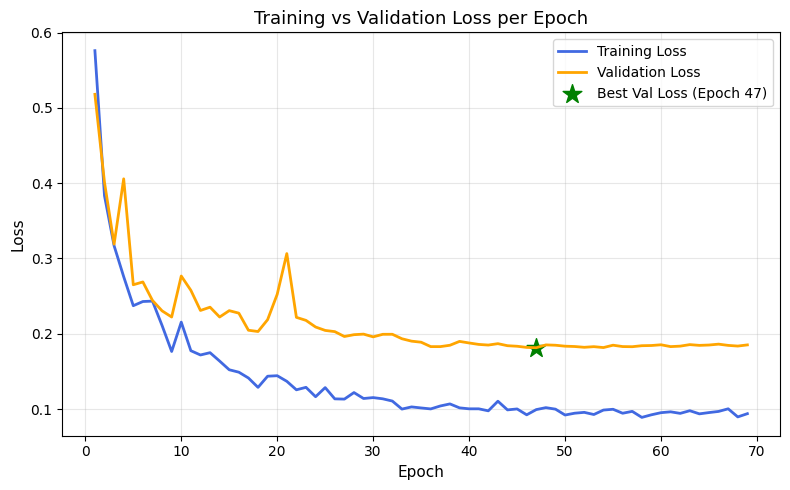

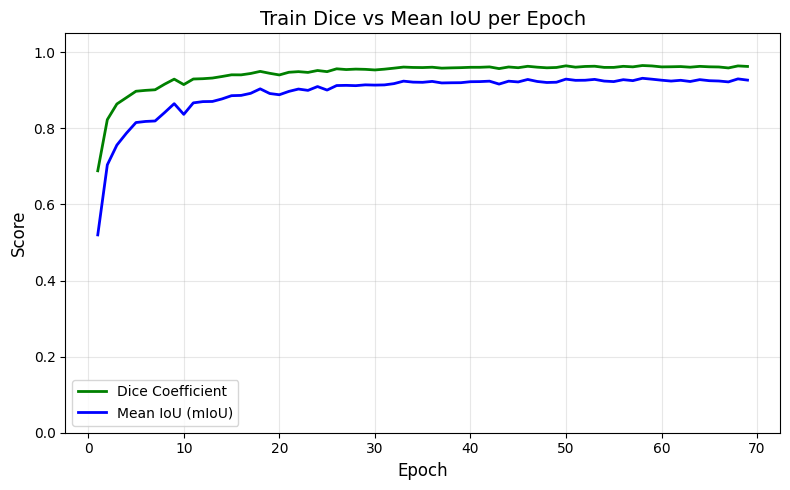

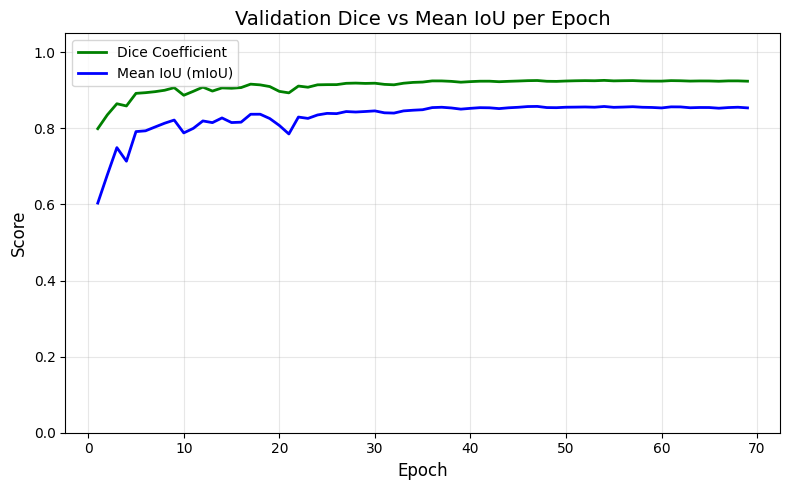

In [17]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# -------------------------------
# 1 Plot Training vs Validation Loss
# -------------------------------
def plot_loss_curves(train_losses, val_losses, save_path=None):
    """
    Plot training and validation loss curves per epoch.

    Args:
        train_losses (list): List of training losses per epoch.
        val_losses (list): List of validation losses per epoch.
        save_path (str, optional): File path to save the plot (e.g. 'loss_curve.png').
    """
    epochs = np.arange(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Training Loss', linewidth=2, color='royalblue')
    plt.plot(epochs, val_losses, label='Validation Loss', linewidth=2, color='orange')

    # Add title and labels
    plt.title("Training vs Validation Loss per Epoch", fontsize=13)
    plt.xlabel("Epoch", fontsize=11)
    plt.ylabel("Loss", fontsize=11)
    plt.grid(alpha=0.3)

    # Highlight best validation epoch
    best_epoch = np.argmin(val_losses) + 1
    best_val = min(val_losses)
    plt.scatter(best_epoch, best_val, color='green', marker='*', s=200,
                label=f'Best Val Loss (Epoch {best_epoch})')

    plt.legend(fontsize=10)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"Saved loss curve to {save_path}")

    plt.show()


# -------------------------------
# 2 Plot Dice vs mIoU over Epochs
# -------------------------------
def plot_dice_vs_miou(dice_scores, miou_scores, save_path=None, is_train=False):
    """
    Plot Dice Coefficient vs Mean IoU (mIoU) per epoch.

    Args:
        dice_scores (list): List of Dice scores per epoch.
        miou_scores (list): List of mean IoU scores per epoch.
        save_path (str, optional): File path to save the figure.
        is_train (bool): If True, labels the plot as 'Train'; otherwise, 'Validation'.
    """

    def to_float_list(vals):
        """Convert a list of values (possibly tensors) to float list."""
        return [v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v) for v in vals]

    dice_scores = to_float_list(dice_scores)
    miou_scores = to_float_list(miou_scores)
    assert len(dice_scores) == len(miou_scores), "Dice and mIoU lists must have same length"

    epochs = np.arange(1, len(dice_scores) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, dice_scores, '-', label='Dice Coefficient', linewidth=2, color='green')
    plt.plot(epochs, miou_scores, '-', label='Mean IoU (mIoU)', linewidth=2, color='blue')

    plt.title(f"{'Train' if is_train else 'Validation'} Dice vs Mean IoU per Epoch", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"Saved metric plot to {save_path}")

    plt.show()


# -------------------------------
# 3 Smoothing Helper
# -------------------------------
def smooth(values, weight=0.1):
    """
    Exponential moving average smoothing for cleaner curves.

    Args:
        values (list): Sequence of metric/loss values.
        weight (float): Smoothing factor (higher = smoother, but less responsive).
    Returns:
        list: Smoothed values.
    """
    smoothed = []
    last = values[0]
    for val in values:
        smoothed_val = last * weight + (1 - weight) * val
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed


# -------------------------------
# 4 Example Usage
# -------------------------------
plot_loss_curves(smooth(train_losses), smooth(val_losses))
plot_dice_vs_miou(smooth(train_dice_scores), smooth(train_miou_scores), is_train=True)
plot_dice_vs_miou(smooth(val_dice_scores), smooth(val_miou_scores), is_train=False)


Saved dashboard to training_dashboard.png


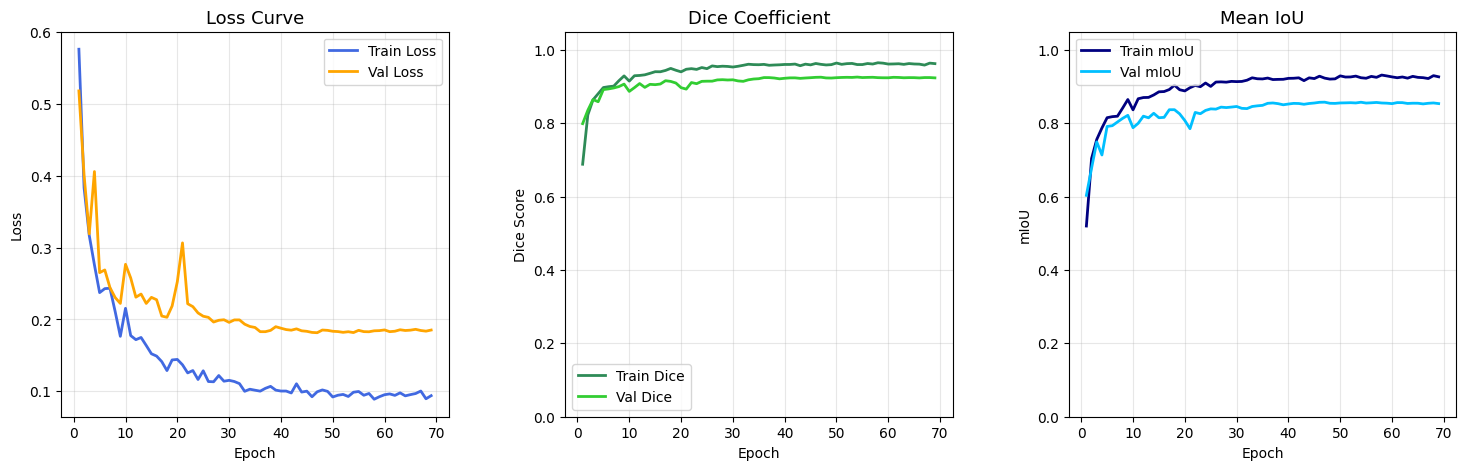

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# -------------------------------
# Helper: smoothing
# -------------------------------
def smooth(values, weight=0.1):
    """Exponential moving average smoothing."""
    smoothed = []
    last = values[0]
    for val in values:
        smoothed_val = last * weight + (1 - weight) * val
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed


# -------------------------------
# Unified Dashboard Plot
# -------------------------------
def plot_training_dashboard(
    train_losses, val_losses,
    train_dice, val_dice,
    train_miou, val_miou,
    save_path=None,
    smooth_weight=0.1
):
    """
    Create a single visualization showing:
    - Training/validation loss
    - Training/validation Dice score
    - Training/validation mean IoU
    
    Args:
        train_losses, val_losses: loss lists
        train_dice, val_dice: Dice score lists
        train_miou, val_miou: mIoU lists
        save_path: optional save path
        smooth_weight: smoothing factor for curves
    """
    # --- Convert possible tensors to float lists ---
    def to_float_list(vals):
        return [v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v) for v in vals]

    train_losses = to_float_list(train_losses)
    val_losses   = to_float_list(val_losses)
    train_dice   = to_float_list(train_dice)
    val_dice     = to_float_list(val_dice)
    train_miou   = to_float_list(train_miou)
    val_miou     = to_float_list(val_miou)

    # --- Smooth curves for clarity ---
    train_losses_s = smooth(train_losses, smooth_weight)
    val_losses_s   = smooth(val_losses, smooth_weight)
    train_dice_s   = smooth(train_dice, smooth_weight)
    val_dice_s     = smooth(val_dice, smooth_weight)
    train_miou_s   = smooth(train_miou, smooth_weight)
    val_miou_s     = smooth(val_miou, smooth_weight)

    epochs = np.arange(1, len(train_losses) + 1)

    # --- Create 3 subplots in one figure ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.subplots_adjust(wspace=0.3)

    # ---------------- Loss Plot ----------------
    axes[0].plot(epochs, train_losses_s, label='Train Loss', color='royalblue', linewidth=2)
    axes[0].plot(epochs, val_losses_s, label='Val Loss', color='orange', linewidth=2)
    axes[0].set_title("Loss Curve", fontsize=13)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].grid(alpha=0.3)
    axes[0].legend()

    # ---------------- Dice Plot ----------------
    axes[1].plot(epochs, train_dice_s, label='Train Dice', color='seagreen', linewidth=2)
    axes[1].plot(epochs, val_dice_s, label='Val Dice', color='limegreen', linewidth=2)
    axes[1].set_title("Dice Coefficient", fontsize=13)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Dice Score")
    axes[1].set_ylim(0, 1.05)
    axes[1].grid(alpha=0.3)
    axes[1].legend()

    # ---------------- mIoU Plot ----------------
    axes[2].plot(epochs, train_miou_s, label='Train mIoU', color='navy', linewidth=2)
    axes[2].plot(epochs, val_miou_s, label='Val mIoU', color='deepskyblue', linewidth=2)
    axes[2].set_title("Mean IoU", fontsize=13)
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("mIoU")
    axes[2].set_ylim(0, 1.05)
    axes[2].grid(alpha=0.3)
    axes[2].legend()

    # --- Optional save ---
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"Saved dashboard to {save_path}")

    plt.show()

plot_training_dashboard(
    train_losses, val_losses,
    train_dice_scores, val_dice_scores,
    train_miou_scores, val_miou_scores,
    save_path="training_dashboard.png"
)


In [55]:
@torch.no_grad()
def decode_mask(mask):
    h, w = mask.shape
    color = np.zeros((h, w, 3), dtype=np.uint8)
    color = COLORMAP[mask]
    return color


    
def visualize_samples(num_samples=3):
    model_path = "/kaggle/working/content/checkpoints/best_model.pt"
    
    model = deeplabv3_resnet50()
    model.classifier[-1] = torch.nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
    checkpoint = torch.load(model_path)
    state_dict = checkpoint['model_state']
    # Remove any aux_classifier keys
    state_dict = {k: v for k, v in state_dict.items() if not k.startswith("aux_classifier.")}
    model.load_state_dict(state_dict)
    
    model.eval()
    model.cpu()  # small batch, run on CPU to avoid GPU mem spikes in Colab
    
    if histimg_mean and histimg_std:
        inv_norm = T.Normalize(mean=[-m/s for m, s in zip(histimg_mean, histimg_std)],
                           std=[1/s for s in histimg_std])

    # Select random indices
    rng = np.random.default_rng(int(time.time()))
    indices = rng.choice(len(val_dataset), size=num_samples, replace=False)
    # indices = random.sample(range(len(val_ds)), num_samples)
    
    # for i in range(num_samples):
    for i in indices:
        img, target = val_dataset[i]  # transformed tensors
        img_in = img.unsqueeze(0)
        out = model(img_in)["out"].argmax(1)[0].cpu().numpy()

        # To display the original image, "un-normalize" and convert back to PIL
        if histimg_mean and histimg_std:
            disp = inv_norm(img).clamp(0,1)
        else:
            disp = img.clamp(0,1)
        disp = TF.to_pil_image(disp)

        gt = target.cpu().numpy()
        pred_color = decode_mask(out)
        gt_color = decode_mask(gt) 

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(disp); plt.title("Image"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(gt_color); plt.title("GT"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(pred_color); plt.title("Prediction"); plt.axis("off")
        plt.show()

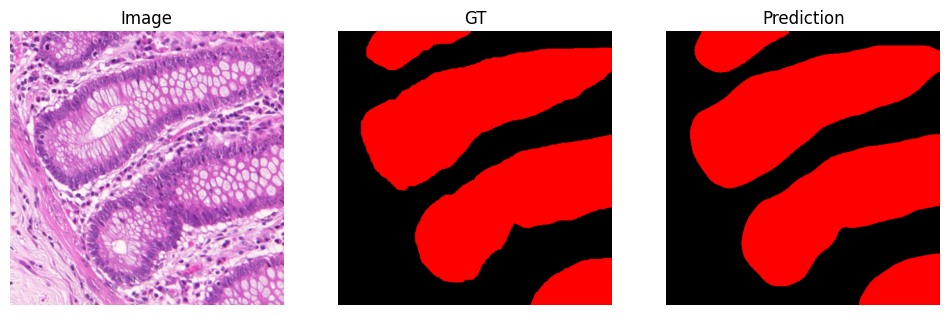

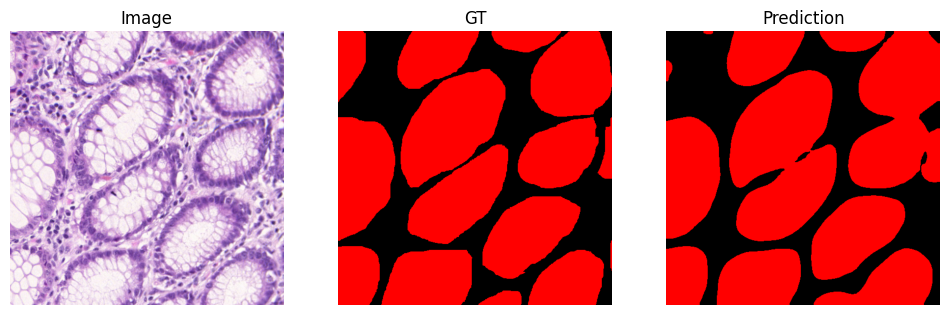

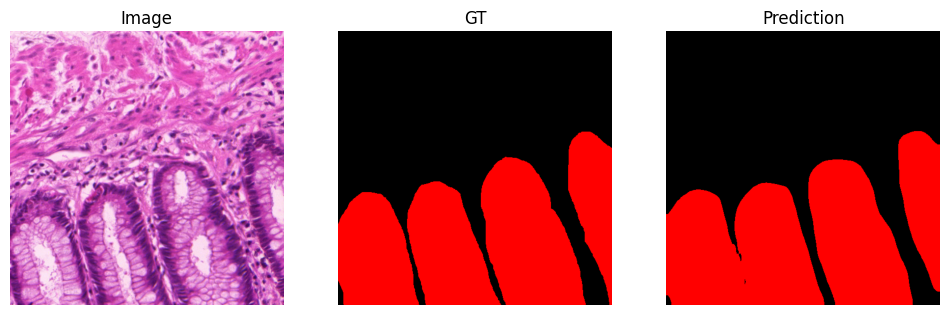

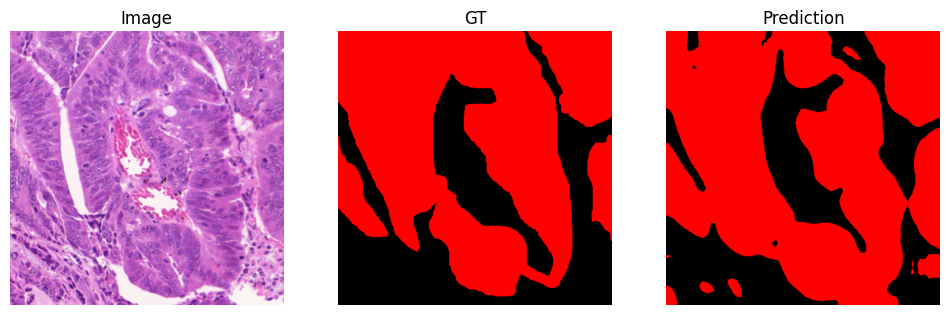

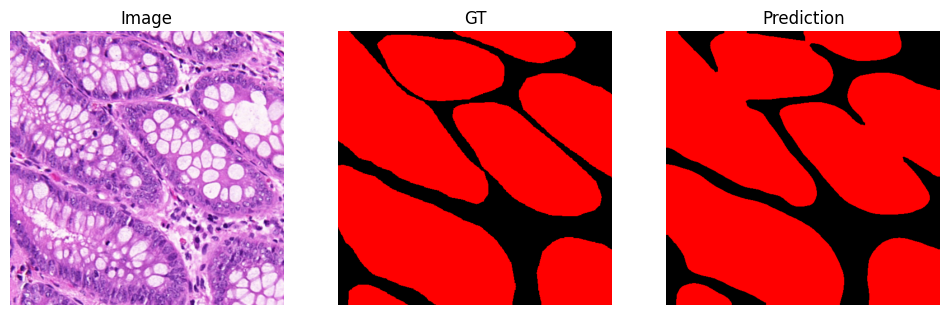

In [56]:
visualize_samples(5)

In [42]:
# -------------------------
# Hybrid ResNet50-UNet training glue (loads DeepLab encoder weights)
# Paste after your dataloaders and hyperparams are defined
# -------------------------
import torchvision.models as models
import torch.nn.functional as F

# -------------------------
# 1) Upsampling / UNet decoder definition
# -------------------------
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu2 = nn.ReLU(inplace=True)
    def forward(self, x, skip=None):
        x = self.up(x)
        if skip is not None:
            if x.shape[2:] != skip.shape[2:]:
                skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=True)
            x = torch.cat([x, skip], dim=1)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x

class ResNet50_UNet(nn.Module):
    def __init__(self, resnet_encoder, n_classes=1):
        super().__init__()
        # encoder (resnet instance)
        self.initial = nn.Sequential(resnet_encoder.conv1, resnet_encoder.bn1, resnet_encoder.relu, resnet_encoder.maxpool)
        self.layer1 = resnet_encoder.layer1
        self.layer2 = resnet_encoder.layer2
        self.layer3 = resnet_encoder.layer3
        self.layer4 = resnet_encoder.layer4

        # decoder
        self.up4 = UpBlock(2048 + 1024, 1024)
        self.up3 = UpBlock(1024 + 512, 512)
        self.up2 = UpBlock(512 + 256, 256)
        self.up1 = UpBlock(256 + 64, 128)

        self.final_up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.final_conv = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, n_classes, kernel_size=1)
        )

    def forward(self, x):
        # encoder forward
        x0 = self.initial(x)            # after conv1+bn+relu (and maxpool)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        # decoder with skip connections
        d4 = self.up4(x4, x3)
        d3 = self.up3(d4, x2)
        d2 = self.up2(d3, x1)
        d1 = self.up1(d2, x0)

        out = self.final_up(d1)
        out = self.final_conv(out)
        return out

# -------------------------
# 2) Robust helper: extract/load ResNet50 encoder weights from a DeepLab checkpoint
# -------------------------
def load_resnet_encoder_from_deeplab_checkpoint(deeplab_checkpoint_path, strict=False, verbose=True):
    """
    Loads a torchvision resnet50 encoder and populates it with weights 
    extracted from a DeepLabv3 checkpoint (supports common key variants).
    """
    resnet = models.resnet50(pretrained=False)

    if not os.path.exists(deeplab_checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found: {deeplab_checkpoint_path}")

    ckpt = torch.load(deeplab_checkpoint_path, map_location='cpu')

    # Handle all common DeepLab checkpoint formats
    if isinstance(ckpt, dict):
        if 'model_state' in ckpt:
            state_dict = ckpt['model_state']
        elif 'model_state_dict' in ckpt:
            state_dict = ckpt['model_state_dict']
        elif 'state_dict' in ckpt:
            state_dict = ckpt['state_dict']
        else:
            # If dict of tensors directly
            if all(isinstance(v, torch.Tensor) for v in ckpt.values()):
                state_dict = ckpt
            else:
                raise RuntimeError("Unsupported checkpoint format (missing model_state keys)")
    else:
        raise RuntimeError("Checkpoint is not a dictionary")

    # Remove auxiliary classifier weights if present
    state_dict = {k: v for k, v in state_dict.items() if not k.startswith("aux_classifier.")}

    # Try mapping common DeepLab key prefixes → ResNet keys
    mapped_state = {}
    for k, v in state_dict.items():
        if k.startswith("backbone.body."):
            new_k = k.replace("backbone.body.", "")
        elif k.startswith("backbone."):
            new_k = k.replace("backbone.", "")
        elif k.startswith("resnet."):
            new_k = k.replace("resnet.", "")
        else:
            new_k = k
        mapped_state[new_k] = v

    # Load into ResNet (ignore mismatched shapes)
    missing, unexpected = resnet.load_state_dict(mapped_state, strict=False)

    if verbose:
        print("Loaded ResNet encoder weights from DeepLab checkpoint")
        print(f"  • Keys loaded: {len(mapped_state)}")
        if missing:
            print(f"  • Missing keys: {len(missing)}")
        if unexpected:
            print(f"  • Unexpected keys: {len(unexpected)}")

    return resnet

# -------------------------
# 3) Build hybrid model from deeplab checkpoint
# -------------------------
def build_hybrid_unet_from_deeplab_ckpt(deeplab_ckpt_path, n_classes=1, freeze_encoder=True, verbose=True):
    """
    Build ResNet50_UNet where encoder is populated from a DeepLabv3 checkpoint saved earlier.
    freeze_encoder: if True, encoder params will have requires_grad=False (useful to train decoder first).
    """
    print(f"Loading ResNet encoder from DeepLab checkpoint: {deeplab_ckpt_path}")
    resnet_encoder = load_resnet_encoder_from_deeplab_checkpoint(deeplab_ckpt_path, verbose=verbose)

    model = ResNet50_UNet(resnet_encoder, n_classes=n_classes)
    if freeze_encoder:
        for name, p in model.named_parameters():
            # freeze encoder layers (those coming from resnet have names like initial.*, layer1.*, etc.)
            if name.startswith('initial') or name.startswith('layer'):
                p.requires_grad = False
    device_ = device if 'device' in globals() else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device_)
    print(f"Hybrid UNet built. Freeze encoder: {freeze_encoder}. Model params: {sum(p.numel() for p in model.parameters()):,}")
    return model

# -------------------------
# 4) Helper: unify logits extraction (works for DeepLab dict or UNet tensor)
# -------------------------
def get_main_logits(outputs):
    """
    Accepts either:
     - DeepLab-style dict -> outputs['out']
     - UNet-style tensor -> outputs (tensor)
     - Some wrappers -> outputs.logits etc.
    Returns: logits tensor [B, C, H, W] (or [B,1,H,W])
    """
    if isinstance(outputs, dict):
        # prefer "out", then "logits", then fallback to first tensor-like value
        if 'out' in outputs:
            return outputs['out']
        if 'logits' in outputs:
            return outputs['logits']
        # fallback: pick first tensor value
        for v in outputs.values():
            if torch.is_tensor(v):
                return v
        raise RuntimeError("Model returned dict but no tensor output was found.")
    elif torch.is_tensor(outputs):
        return outputs
    else:
        raise RuntimeError("Unexpected model output type")

# -------------------------
# 5) Criterion selection for hybrid model
# -------------------------
def make_criterion(num_classes):
    if num_classes == 1:
        return nn.BCEWithLogitsLoss()
    else:
        return nn.CrossEntropyLoss(ignore_index=255)

# -------------------------
# 6) Dice utility (batch-average)
# -------------------------
def simple_dice_batch(preds, targets, eps=1e-6):
    """
    preds: [B,H,W] int class preds (0..C-1) or binary (0/1)
    targets: [B,H,W] int class targets
    For multiclass, computes mean Dice across classes (excluding ignore) by converting to one-hot.
    Returns scalar in [0,1]
    """
    if preds.ndim != 3:
        raise ValueError("preds must be [B,H,W]")
    B = preds.shape[0]
    preds = preds.long()
    targets = targets.long()
    if NUM_CLASSES == 1:
        preds_bin = (preds != 0).float()
        targets_bin = (targets != 0).float()
        inter = (preds_bin * targets_bin).sum((1,2))
        denom = preds_bin.sum((1,2)) + targets_bin.sum((1,2))
        dice = ((2 * inter + eps) / (denom + eps)).mean().item()
        return dice
    else:
        # one-hot and mean over classes (skip background class 0 optionally)
        dice_per_sample = []
        for b in range(B):
            dice_classes = []
            for c in range(1, NUM_CLASSES):  # skipping background
                p_c = (preds[b] == c).float()
                t_c = (targets[b] == c).float()
                inter = (p_c * t_c).sum()
                denom = p_c.sum() + t_c.sum()
                dice_classes.append(((2 * inter + eps) / (denom + eps)).item())
            if dice_classes:
                dice_per_sample.append(np.mean(dice_classes))
            else:
                dice_per_sample.append(0.0)
        return float(np.mean(dice_per_sample))

# -------------------------
# 7) Training / Validation wrappers (model-agnostic)
# -------------------------
def train_one_epoch_hybrid(model, train_loader, optimizer, criterion, scaler, epoch, print_freq=20):
    model.train()
    running_loss = 0.0
    n_samples = 0
    conf = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=device)
    dice_vals = []

    for it, (images, targets) in enumerate(train_loader, 1):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            outputs = model(images)
            logits = get_main_logits(outputs)
            # ensure logits size matches targets spatial dims
            if logits.shape[2:] != targets.shape[1:]:
                logits = F.interpolate(logits, size=targets.shape[1:], mode='bilinear', align_corners=True)

            if NUM_CLASSES == 1:
                # logits maybe [B,1,H,W] or [B,H,W] — standardize
                if logits.dim() == 3:
                    logits = logits.unsqueeze(1)
                loss = criterion(logits.squeeze(1), targets.float())
            else:
                loss = criterion(logits, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch = images.size(0)
        running_loss += loss.item() * batch
        n_samples += batch

        # metrics
        with torch.no_grad():
            if NUM_CLASSES == 1:
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).long().squeeze(1)
            else:
                preds = torch.argmax(logits, dim=1)
            # update confusion
            conf += fast_confusion_matrix(preds, targets, NUM_CLASSES, ignore_index=255)
            dice_vals.append(simple_dice_batch(preds.cpu(), targets.cpu()))

        if it % print_freq == 0:
            miou, pixacc, _ = miou_and_pixel_acc(conf.cpu())
            print(f"[Train] Epoch {epoch} | Iter {it}/{len(train_loader)} | loss {running_loss/n_samples:.4f} | mIoU {miou*100:.2f}% | pixAcc {pixacc*100:.2f}%")

    epoch_loss = running_loss / (n_samples + 1e-12)
    miou, pixacc, _ = miou_and_pixel_acc(conf.cpu())
    epoch_dice = float(np.mean(dice_vals)) if dice_vals else 0.0
    return epoch_loss, miou, pixacc, epoch_dice

@torch.no_grad()
def validate_hybrid(model, val_loader, criterion, epoch):
    model.eval()
    val_loss = 0.0
    n_samples = 0
    conf = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=device)
    dice_vals = []

    for images, targets in val_loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            outputs = model(images)
            logits = get_main_logits(outputs)
            if logits.shape[2:] != targets.shape[1:]:
                logits = F.interpolate(logits, size=targets.shape[1:], mode='bilinear', align_corners=True)
            if NUM_CLASSES == 1:
                if logits.dim() == 3:
                    logits = logits.unsqueeze(1)
                loss = criterion(logits.squeeze(1), targets.float())
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).long().squeeze(1)
            else:
                loss = criterion(logits, targets)
                preds = torch.argmax(logits, dim=1)

        batch = images.size(0)
        val_loss += loss.item() * batch
        n_samples += batch

        conf += fast_confusion_matrix(preds, targets, NUM_CLASSES, ignore_index=255)
        dice_vals.append(simple_dice_batch(preds.cpu(), targets.cpu()))

    avg_loss = val_loss / (n_samples + 1e-12)
    miou, pixacc, cls_iou = miou_and_pixel_acc(conf.cpu())
    avg_dice = float(np.mean(dice_vals)) if dice_vals else 0.0
    print(f"[VAL] Epoch {epoch} | loss {avg_loss:.4f} | mIoU {miou*100:.2f}% | pixAcc {pixacc*100:.2f}% | Dice {avg_dice*100:.2f}%")
    return avg_loss, miou, pixacc, cls_iou, avg_dice

# -------------------------
# 8) Full training loop (use Dice as primary metric)
# -------------------------
def train_hybrid_from_deeplab_ckpt(deeplab_ckpt_path,
                                   model_save_dir=CHECKPOINT_DIR,
                                   n_classes=NUM_CLASSES,
                                   freeze_encoder=True,
                                   initial_epochs_freeze=5,
                                   num_epochs=NUM_EPOCHS,
                                   patience=PATIENCE,
                                   lr=LR,
                                   weight_decay=WEIGHT_DECAY):
    os.makedirs(model_save_dir, exist_ok=True)

    model = build_hybrid_unet_from_deeplab_ckpt(deeplab_ckpt_path, n_classes=n_classes, freeze_encoder=freeze_encoder)
    criterion = make_criterion(n_classes)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
    scaler_local = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
    lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

    best_dice = 0.0
    epochs_no_improve = 0

    history = {'train_loss':[], 'val_loss':[], 'train_dice':[], 'val_dice':[], 'train_miou':[], 'val_miou':[]}

    for epoch in range(1, num_epochs + 1):
        # optionally unfreeze encoder after initial epochs
        if freeze_encoder and epoch == initial_epochs_freeze + 1:
            print("Unfreezing encoder for fine-tuning.")
            for p in model.parameters():
                p.requires_grad = True
            # re-create optimizer to include encoder params
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr * 0.2, weight_decay=weight_decay)
            lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
            scaler_local = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

        train_loss, train_miou, train_pix, train_dice = train_one_epoch_hybrid(model, train_loader, optimizer, criterion, scaler_local, epoch, PRINT_FREQ)
        val_loss, val_miou, val_pix, cls_iou, val_dice = validate_hybrid(model, val_loader, criterion, epoch)

        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
        history['train_dice'].append(train_dice); history['val_dice'].append(val_dice)
        history['train_miou'].append(train_miou); history['val_miou'].append(val_miou)

        # scheduler step on Dice
        lr_sched.step(val_dice)

        # checkpoint best by Dice
        if val_dice > best_dice:
            best_dice = val_dice
            epochs_no_improve = 0
            ck = {
                'epoch': epoch,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'best_dice': best_dice,
                'history': history
            }
            best_path = os.path.join(model_save_dir, f"resnet50_unet_best_epoch_{epoch:03d}_dice_{best_dice:.4f}.pth")
            torch.save(ck, best_path)
            torch.save(ck, os.path.join(model_save_dir, "resnet50_unet_best.pth"))
            print(f"Saved new best model to {best_path} (Dice={best_dice:.4f})")
        else:
            epochs_no_improve += 1
            print(f"No Dice improvement for {epochs_no_improve} epochs (patience {patience})")

        # early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} (no Dice improvement for {patience} epochs)")
            break

    # load best weights
    best_file = os.path.join(model_save_dir, "resnet50_unet_best.pth")
    if os.path.exists(best_file):
        ck = torch.load(best_file, map_location=device)
        model.load_state_dict(ck['model_state'])
        print(f"Loaded best model from {best_file} (best_dice={ck.get('best_dice')})")

    return model, history




In [43]:
# -------------------------
# Usage example:
# -------------------------
deeplab_checkpoint = "/kaggle/working/content/checkpoints/best_model.pt"  # your existing deeplab checkpoint path
        
model, history = train_hybrid_from_deeplab_ckpt(deeplab_checkpoint,
                                                model_save_dir=CHECKPOINT_DIR,
                                                n_classes=NUM_CLASSES,
                                                freeze_encoder=True,
                                                initial_epochs_freeze=5,
                                                num_epochs=NUM_EPOCHS,
                                                patience=PATIENCE,
                                                lr=LR)


Loading ResNet encoder from DeepLab checkpoint: /kaggle/working/content/checkpoints/best_model.pt
Loaded ResNet encoder weights from DeepLab checkpoint
  • Keys loaded: 362
  • Missing keys: 2
  • Unexpected keys: 44
Hybrid UNet built. Freeze encoder: True. Model params: 73,650,882
[VAL] Epoch 1 | loss 0.3929 | mIoU 77.46% | pixAcc 87.32% | Dice 87.40%
Saved new best model to /kaggle/working/content/checkpoints/resnet50_unet_best_epoch_001_dice_0.8740.pth (Dice=0.8740)
[VAL] Epoch 2 | loss 0.2770 | mIoU 80.63% | pixAcc 89.28% | Dice 89.20%
Saved new best model to /kaggle/working/content/checkpoints/resnet50_unet_best_epoch_002_dice_0.8920.pth (Dice=0.8920)
[VAL] Epoch 3 | loss 0.3336 | mIoU 77.44% | pixAcc 87.44% | Dice 88.67%
No Dice improvement for 1 epochs (patience 15)
[VAL] Epoch 4 | loss 0.2452 | mIoU 81.56% | pixAcc 89.85% | Dice 89.61%
Saved new best model to /kaggle/working/content/checkpoints/resnet50_unet_best_epoch_004_dice_0.8961.pth (Dice=0.8961)
[VAL] Epoch 5 | loss 0.28

In [57]:
# visualize_samples(
#     model_path="/kaggle/working/content/checkpoints/resnet50_unet_best.pth",
#     val_dataset=val_dataset,
#     num_samples=3,
#     device='cuda' if torch.cuda.is_available() else 'cpu'
# )

SyntaxError: incomplete input (588014226.py, line 6)